In [1]:
import pickle
import numpy as np
import matplotlib as plt

from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

from scipy.stats import randint, loguniform,  uniform
from sklearn.metrics import f1_score
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, precision_score, recall_score

In [2]:
def load(file):
    with open(file, 'rb') as f:
        return pickle.load(f)
    
def save(data, file):
    with open(file, 'wb') as f:
        pickle.dump(data, f)

In [3]:
train = load('data/train_classical')
validate = load('data/validate_classical')
test = load('data/test_classical')

In [4]:
def split(data, cols=None):
    labels = np.array(data['class'])
    features = data.drop(['frequency', 'class', 'theory'], axis = 1)
    if cols is not None:
      features = features[cols]
    feature_list = list(features.columns)
    features = np.nan_to_num(np.array(features).astype(np.float32))
    return features, labels, feature_list

def get_split(cols=None):
    train_features, train_labels, feature_list = split(train, cols)
    num_train = len(train_labels)
    validate_features, validate_labels, _ = split(validate, cols)
    num_validate = len(validate_labels)
    test_features, test_labels, _ = split(test, cols)
    ps = PredefinedSplit(np.concatenate((np.full((num_train,), -1), np.full((num_validate,), 0))))
    
    features = np.concatenate((train_features, validate_features))
    labels = np.concatenate((train_labels, validate_labels))
    return (features, validate_features, test_features, labels, validate_labels, test_labels, ps, feature_list)

In [5]:
def run(search, train_features, train_labels):
    search.fit(train_features, train_labels)
    return search.best_score_

def export_prc(name, labels, probs):
    precisions, recalls, thresholds = precision_recall_curve(labels, probs)
    
    t = ' '.join([f'({recall:.8f},{precision:.8f})' for precision,recall in zip(precisions,recalls)])
    with open('results/' + name, 'w') as f:
        f.write(t)
    
    return precisions, recalls, thresholds

In [6]:
train_features, validate_features, test_features, train_labels, validate_labels, test_labels, ps, feature_list = get_split()
np.bincount(train_labels)

array([4237, 1788])

# Decision Tree

In [7]:
dt = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': randint(1, 100000),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2'],
}, n_iter=10000, cv=ps, random_state=42, n_jobs=-1, scoring='average_precision')

run(dt, train_features, train_labels)

0.3983861433611597

# Random Forest

In [8]:
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

grid = {
  'n_estimators': randint(10, 1000),
  'max_features': [2,4,8],
  'max_depth': max_depth,
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4],
  'bootstrap': [True, False]
}

rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), grid, n_iter=1000, cv=ps, random_state=42, n_jobs=-1, scoring='average_precision')
run(rf, train_features, train_labels)

0.4747743632481278

# Gradient Boosted Trees

In [9]:
gbt = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': loguniform(1e-5, 1e5),
    'n_estimators': randint(10, 1000),
    'subsample': uniform(0.01, 1.0),
    'criterion': ['friedman_mse', 'squared_error'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}, n_iter=1000, cv=ps, random_state=42, n_jobs=-1, scoring='average_precision')

run(gbt, train_features, train_labels)

/opt/conda/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:923: RuntimeWarning: overflow encountered in exp
  * np.sum(sample_weight * np.exp(-(2 * y - 1) * raw_predictions))
/opt/conda/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:939: RuntimeWarning: overflow encountered in exp
  return y_ * np.exp(-y_ * raw_predictions.ravel())
/opt/conda/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:959: RuntimeWarning: overflow encountered in exp
  numerator = np.sum(y_ * sample_weight * np.exp(-y_ * raw_predictions))
/opt/conda/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:960: RuntimeWarning: overflow encountered in exp
  denominator = np.sum(sample_weight * np.exp(-y_ * raw_predictions))
/opt/conda/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:966: RuntimeWarning: invalid value encountered in double_scalars
  tree.value[leaf, 0, 0] = numerator / denominator
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_validation.p

0.44070016250479127

# kNN

In [10]:
knn = RandomizedSearchCV(KNeighborsClassifier(), {
    'n_neighbors': randint(3, 30)
}, n_iter=1000, cv=ps, random_state=42, n_jobs=-1, scoring='average_precision')

run(knn, train_features, train_labels)

0.3311685029371058

# Multilayer Perceptron

In [11]:
nn = RandomizedSearchCV(MLPClassifier(random_state=42), {
    'hidden_layer_sizes': [[100, 100], [200, 100]],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': loguniform(1e-7, 1e-1),
    'learning_rate_init': loguniform(1e-5, 1e-1),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': randint(100, 1000)
}, n_iter=1000, cv=ps, random_state=42, n_jobs=-1, scoring='average_precision')

run(nn, train_features, train_labels)

/opt/conda/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:923: RuntimeWarning: overflow encountered in exp
  * np.sum(sample_weight * np.exp(-(2 * y - 1) * raw_predictions))
/opt/conda/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:939: RuntimeWarning: overflow encountered in exp
  return y_ * np.exp(-y_ * raw_predictions.ravel())
/opt/conda/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:959: RuntimeWarning: overflow encountered in exp
  numerator = np.sum(y_ * sample_weight * np.exp(-y_ * raw_predictions))
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/conda/lib/python3.8/site-packages/sklearn/ensemble/_gb_losses.py:960: RuntimeWarning: overflow encountered in exp
  denominator = np.sum(sample_weight * np.exp(-y_ * raw_predictions))
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776:

0.39983671017473515

# Evaluation

Precision: 0.584070796460177
Recall: 0.21221864951768488


(array([0.29229323, 0.29506641, 0.29534663, 0.29590866, 0.29647283,
        0.29846449, 0.29970902, 0.30058366, 0.30087634, 0.30175781,
        0.30234834, 0.30353635, 0.30383481, 0.30413386, 0.30654762,
        0.30715706, 0.30746269, 0.31055276, 0.31086519, 0.31117825,
        0.31149194, 0.31364562, 0.31492843, 0.31525077, 0.31557377,
        0.31622177, 0.31551901, 0.31813472, 0.31846473, 0.31879543,
        0.31912682, 0.31875   , 0.32172996, 0.32206969, 0.32578209,
        0.32648649, 0.32683983, 0.32608696, 0.32644178, 0.32967033,
        0.330033  , 0.33039648, 0.33076075, 0.3318535 , 0.33183352,
        0.33258174, 0.33295711, 0.33181818, 0.33219568, 0.33295325,
        0.33565621, 0.33567251, 0.33606557, 0.33645955, 0.33685446,
        0.33725029, 0.33971292, 0.34011976, 0.34178744, 0.34220073,
        0.34140436, 0.34181818, 0.34223301, 0.34452736, 0.34495641,
        0.34538653, 0.34581773, 0.34625   , 0.35018963, 0.35063291,
        0.35107731, 0.35152284, 0.35400517, 0.35

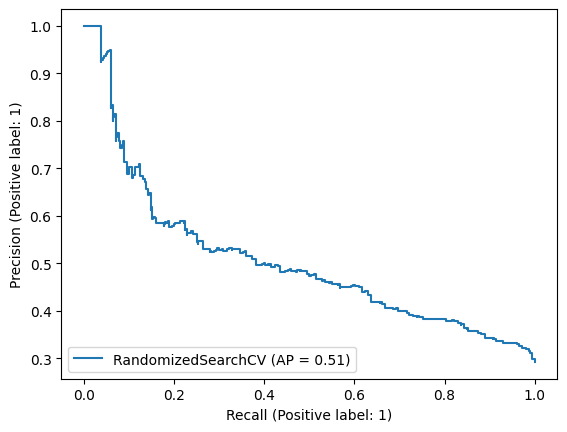

In [19]:
rf_pred = rf.predict_proba(test_features)[:,1]
print(f'Precision: {precision_score(test_labels, rf_pred > 0.5)}')
print(f'Recall: {recall_score(test_labels, rf_pred > 0.5)}')

PrecisionRecallDisplay.from_estimator(rf, test_features, test_labels)
export_prc('data_rf', test_labels, rf_pred)

# Comparision with SLOC (linear SVM)

In [14]:
train_features1, _, test_features1, train_labels1, _, test_labels1, ps1, feature_list1 = get_split(['sloc'])

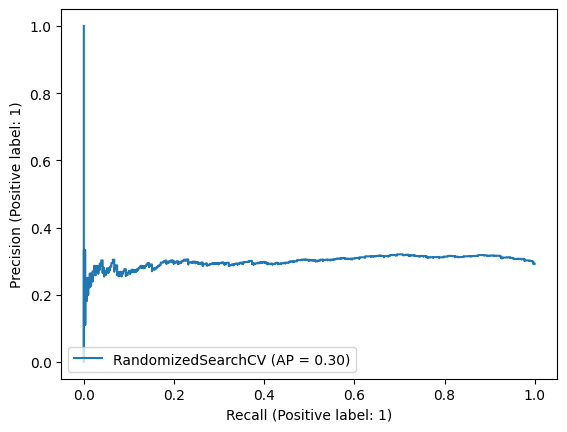

In [15]:
linsvm = RandomizedSearchCV(LinearSVC(random_state=42), {
    'dual': [False],
    'C': loguniform(0.1, 10)
}, n_iter=10000, cv=ps1, random_state=42, n_jobs=-1, scoring='average_precision')

run(linsvm, train_features1, train_labels1)
_ = PrecisionRecallDisplay.from_estimator(linsvm, test_features1, test_labels1)

# Which features are important?

In [16]:
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

grid = {
    'n_estimators': randint(10, 1000),
    'max_features': [2,4,8],
    'max_depth': max_depth,
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

remaining = feature_list.copy()
rf1 = RandomizedSearchCV(RandomForestClassifier(random_state=42), grid, n_iter=1000, cv=ps, random_state=42, n_jobs=-1, scoring='average_precision')
score = run(rf1, train_features, train_labels)
print(f'Initial Score: {score:.4f}')

Initial Score: 0.4748


In [17]:
for _ in feature_list[:-1]:
    best_feature = ''
    best_score = -1.0
    for feature in remaining:
        fl = remaining.copy()
        fl.remove(feature)
        train_f, _, test_f, train_l, _, test_l, p, _ = get_split(fl)
        rf1 = RandomizedSearchCV(RandomForestClassifier(random_state=42), grid, n_iter=1000, cv=p, random_state=42, n_jobs=-1, scoring='average_precision')
        score = run(rf1, train_f, train_l)
        if score > best_score:
            best_score = score
            best_feature = feature
    print(f'Removing {best_feature} with score {best_score:.4f}')
    remaining.remove(best_feature)
print(remaining)

Removing in_med with score 0.4852
Removing close_min with score 0.4919
Removing cluster_max with score 0.4869
Removing cluster_med with score 0.4928
Removing out_avg with score 0.4967
Removing sloc with score 0.4934
Removing between_min with score 0.4885
Removing cluster_avg with score 0.4883
Removing eigen_max with score 0.4926
Removing close_max with score 0.4891
Removing in_max with score 0.4924
Removing cluster_min with score 0.4980
Removing eigen_med with score 0.5021
Removing close_med with score 0.5083
Removing eigen_min with score 0.5051
Removing out_min with score 0.5007
Removing in_min with score 0.4944
Removing between_avg with score 0.4876
Removing out_med with score 0.4813
Removing eigen_avg with score 0.4722
Removing between_med with score 0.4204
Removing out_max with score 0.3837
Removing close_avg with score 0.3565
Removing between_max with score 0.3422
['in_avg']


# Predict Manually labelled dataset

Precision: 1.0
Recall: 0.42857142857142855


(array([0.5       , 0.53333333, 0.68965517, 0.67857143, 0.76      ,
        0.79166667, 0.7826087 , 0.77272727, 0.80952381, 0.85      ,
        0.84210526, 0.88888889, 0.94117647, 0.9375    , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        ]),
 array([1.        , 0.68571429, 0.57142857, 0.54285714, 0.54285714,
        0.54285714, 0.51428571, 0.48571429, 0.48571429, 0.48571429,
        0.45714286, 0.45714286, 0.45714286, 0.42857143, 0.42857143,
        0.4       , 0.37142857, 0.34285714, 0.31428571, 0.28571429,
        0.17142857, 0.        ]),
 array([0.        , 0.00453443, 0.00830868, 0.00878554, 0.00907391,
        0.19753086, 0.22222222, 0.23910233, 0.25116469, 0.26379369,
        0.39506173, 0.41429802, 0.42428752, 0.48148148, 0.52305295,
        0.59712702, 0.9840869 , 0.98438255, 0.98771568, 0.99218875,
        1.        ]))

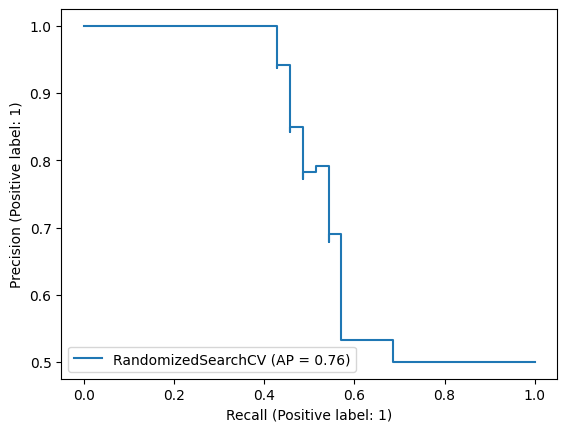

In [21]:
manual_data = load('data/manual_data')

manual_labels = np.array(manual_data['bad'])
manual_features = manual_data.drop(['frequency', 'class', 'theory', 'bad'], axis = 1)
manual_features = np.nan_to_num(np.array(manual_features).astype(np.float32))
print(f'Precision: {precision_score(manual_labels, rf.predict(manual_features))}')
print(f'Recall: {recall_score(manual_labels, rf.predict(manual_features))}')
_ = PrecisionRecallDisplay.from_estimator(rf, manual_features, manual_labels)
export_prc('manual_rf', manual_labels, rf.predict_proba(manual_features)[:,1])